In [1]:
import numpy as np
import pandas as pd
import scipy as sp
%matplotlib widget
import copy as cp
import math
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler

# Poisson regression
## Basics
Is clear in Inspeccion that the pdf for sold_quantity follows a poisson distribution for days>>1.  
This means thata simple (perhaps naive) approach is to use a Poisson regression for each `sku`

Let $\mathbf{x}$ be the independent variables to consider (simple case, days). Then the model assumes that  
$\log(\operatorname {E} (Y\mid \mathbf {x} ))=\alpha +\mathbf {\beta } '\mathbf {x}$  
or more in compact form:  
$\log ⁡ ( E ⁡ ( Y | x ) ) = \theta  \mathbf{x}$

and thus  
$E(Y|x) = e^{\theta \mathbf{x}}$
## MLE
Given a set of parameters θ and an input vector x, the mean of the predicted Poisson distribution, as stated above, is given by  

$\lambda := E ⁡ ( Y ∣ x ) = e^{\theta x} $

and thus, the Poisson distribution's probability mass function is given by

$p ( y | x ; \theta ) = \frac{\lambda ^ y}{ y !} e^{-\lambda} = e^{y \theta \mathbf{x}} \frac{e^{ - e^{\theta\mathbf{x}}}}{ y! }$

Now suppose we are given a data set consisting of m vectors $\mathbf{x_i}, i = 1 ,..., m$  along with a set of m values $y_1 ,... , y_m$ . Then, for a given set of parameters θ, the probability of attaining this particular set of data is given by 

  $p(y_{1},\ldots ,y_{m}\mid x_{1},\ldots ,x_{m};\theta )=\prod _{i=1}^{m}{\frac {e^{y_{i}\theta 'x_{i}}e^{-e^{\theta 'x_{i}}}}{y_{i}!}}$

By the method of Maximum likelihood,we wish to find the set of parameters θ that makes this probability as large as possible. By defining the likelihood as :

${\displaystyle L(\theta \mid X,Y)=\prod _{i=1}^{m}{\frac {e^{y_{i}\theta 'x_{i}}e^{-e^{\theta 'x_{i}}}}{y_{i}!}}.} {\displaystyle L(\theta \mid X,Y)=\prod _{i=1}^{m}{\frac {e^{y_{i}\theta 'x_{i}}e^{-e^{\theta 'x_{i}}}}{y_{i}!}}.}$

Note that the expression on the right hand side has not actually changed. A formula in this form is typically difficult to work with; instead, one uses the log-likelihood:

${\displaystyle \ell (\theta \mid X,Y)=\log L(\theta \mid X,Y)=\sum _{i=1}^{m}\left(y_{i}\theta 'x_{i}-e^{\theta 'x_{i}}-\log(y_{i}!)\right).} $

Notice that the parameters θ only appear in the first two terms of each term in the summation. Therefore, given that we are only interested in finding the best value for θ we may drop the yi! and simply write

${\displaystyle \ell (\theta \mid X,Y)=\sum _{i=1}^{m}\left(y_{i}\theta 'x_{i}-e^{\theta 'x_{i}}\right).} {\displaystyle \ell (\theta \mid X,Y)=\sum _{i=1}^{m}\left(y_{i}\theta 'x_{i}-e^{\theta 'x_{i}}\right).}$

So our parameter fitting problem reduces to solve ${\frac {\partial \ell (\theta \mid X,Y)}{\partial \theta }}=0 $ 

## Implementation

In [2]:
## Load the data
data_train = pd.read_parquet("Data/train_data.parquet",engine="pyarrow")
data_test = pd.read_csv("Data/test_data.csv")
data_train['date'] =  pd.to_datetime(data_train['date'])

Text(0, 0.5, 'sold_quantity comulative')

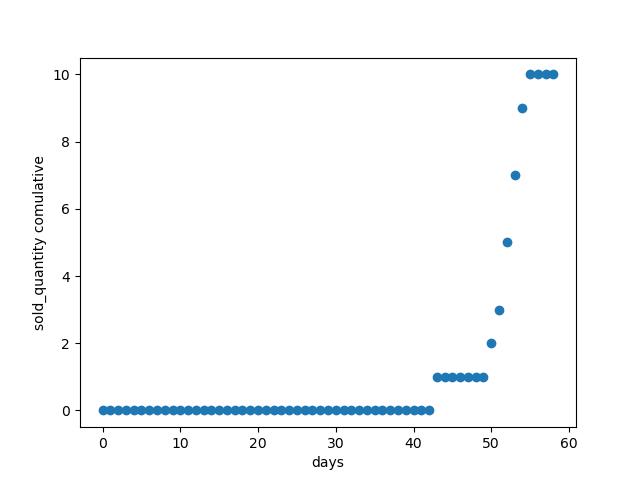

In [21]:
#Choose one sku
sku = np.random.choice(data_train.sku.unique(),1)[0]
sku = 328494
#sku = 659780

data = data_train[data_train.sku == sku]

y = np.cumsum(data.sold_quantity.values)
x = np.arange(y.size) 
x = x.reshape(-1,1)

plt.close("all")
plt.figure()
plt.scatter(x,y)
plt.xlabel("days")
plt.ylabel("sold_quantity comulative")

In [11]:
## En principio no utilizamos MLE para fitear, no sé que metodo usa linear_fit. Checkear

clf = linear_model.PoissonRegressor(alpha = 1, max_iter=1000)
clf.fit(x,y)

PoissonRegressor(alpha=1, max_iter=1000)

In [12]:
def Poisson(y:np.array,x,intercept,c):
    """ Returns the poisson distribution for the probability of get y events given x with lambda = intercept + c*x
    Parameters:
        y: np.array
        x: int, features  of the model
        intercept: float
        c: float
    Returns:
        Probability distribution array"""
  
    lamb = np.exp(intercept + x*c)
    a = lamb**y*np.exp(-lamb)
    b = [math.factorial(i) for i in y]
    return a/b

def pdf_n_days(dist_prob,n):
    """Returns the pdf after n iterations given the distribution probability of one iteration
    This is assuming that every iteration is independent of the previous one. So in this case the pdf is the convolution.
    Paraments:
    dist_prob (np.array): distribuion probability of one iteration
    n (integer): number of iterations
    
    Returns:
    probability(np.array): pdf after n iterations"""
    prob = cp.copy(dist_prob)
    for i in range(n):
        prob = np.convolve(prob,dist_prob)
    return prob



score =  0.9554574834337286
coefficients =  -10.149488062377719 [0.22107212]


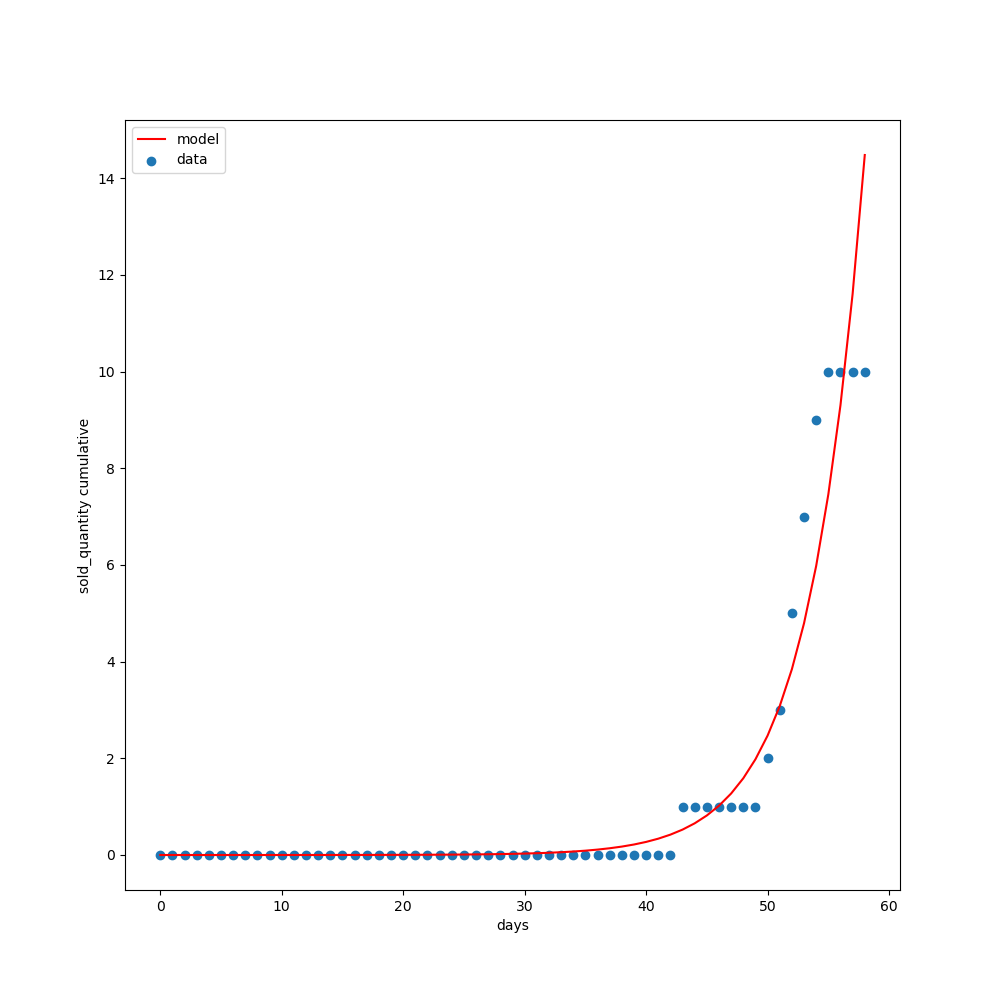

In [22]:
print("score = ",clf.score(x,y))
print("coefficients = ", clf.intercept_, clf.coef_)
fig, axes = plt.subplots(1,1,figsize = (10,10))
axes.scatter(x,y,label = "data")
axes.plot(x,np.exp(clf.intercept_ + clf.coef_[0]*x),"r",label = "model")

axes.set_ylabel("sold_quantity cumulative")
axes.set_xlabel("days")
axes.legend()

Una vez que tenemos el modelo, podemos preguntarnos por la distribución de probabilidades al cabo de N días.

Text(0, 0.5, 'prob')

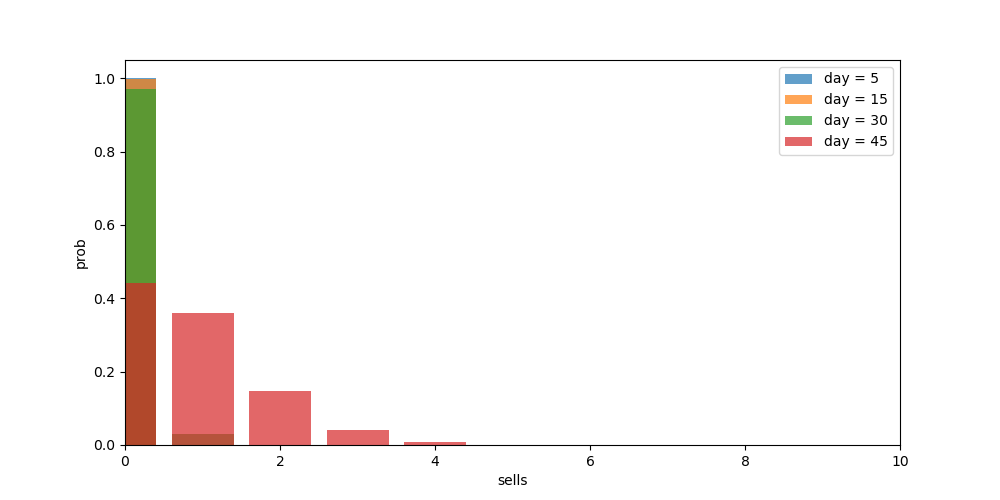

In [14]:
day_list = [5,15,30,45]
coef = clf.intercept_,clf.coef_[0]
sells = np.arange(100,dtype = int)

fig,axes = plt.subplots(1,1,figsize = (10,5))
dist_prob,bins = np.histogram(data.sold_quantity.values,bins = np.arange(0,5,1))
dist_prob = dist_prob/dist_prob.sum()


for day in day_list:
    y = Poisson(sells,day,coef[0],coef[1])
    axes.bar(sells,y,label = f"day = {day}",alpha = .7) 
    
axes.set_xlim(0,10)
axes.set_xlabel("sells")
axes.legend()
axes.set_ylabel("prob")

Cómo se compara esto con los histogramas con el obtenidos mediante convolución? (See Inspección)

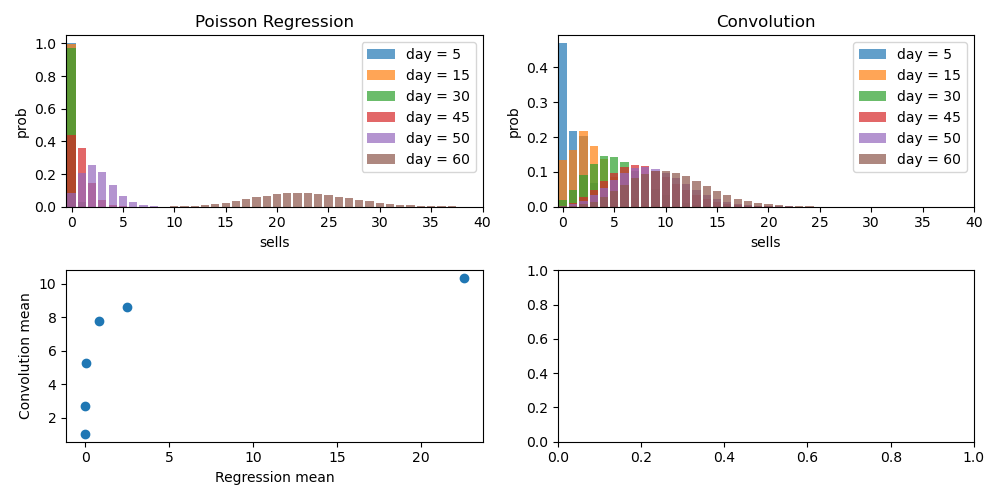

In [15]:
day_list = [5,15,30,45,50,60]
coef = clf.intercept_,clf.coef_[0]
sells = np.arange(100,dtype = int)

fig,axes = plt.subplots(2,2,figsize = (10,5))

dist_prob,bins = np.histogram(data.sold_quantity.values,bins = np.arange(0,5,1))
dist_prob = dist_prob/dist_prob.sum()

means_regression = []
means_convolution = []

for day in day_list:

    y = Poisson(sells,day,coef[0],coef[1])
    m = np.exp(coef[0] + coef[1]*day)
    means_regression.append(m)
    
    axes[0][0].bar(sells,y,label = f"day = {day}",alpha = .7)
    
    y_aux = pdf_n_days(dist_prob,day)
    m2 = np.sum(y_aux*np.arange(y_aux.size))
    means_convolution.append(m2)
    
    axes[0][1].bar(np.arange(y_aux.size),y_aux,label = f"day = {day}",alpha = .7)
    
axes[0][0].set_title("Poisson Regression")
axes[0][0].set_xlabel("sells")
axes[0][0].legend()
axes[0][0].set_ylabel("prob")

axes[0][1].set_title("Convolution")
axes[0][1].set_xlabel("sells")
axes[0][1].legend()
axes[0][1].set_ylabel("prob")

xlim = 40
axes[0][0].set_xlim(-0.5,xlim)
axes[0][1].set_xlim(-.5,xlim)

axes[1][0].scatter(means_regression,means_convolution)
axes[1][0].set_xlabel("Regression mean")
axes[1][0].set_ylabel("Convolution mean")

fig.tight_layout()

### Scores
    Parece andar muy bien. Determinemos el score para las primeras 1000 muestras.

In [16]:
#Lets make an histogram

scores = np.array([])

for example in data_train.sku.unique()[:1000]:
    d = data_train[data_train.sku == example]
    Y = np.cumsum(d.sold_quantity.values)
    X = np.arange(Y.size) 
    X = X.reshape(-1,1)
    poisson_model= linear_model.PoissonRegressor(max_iter=10000,verbose = 0)
    poisson_model.fit(X,Y)
    score = poisson_model.score(X,Y)
    scores = np.append(scores,score)


/home/thungur/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/link.py:84: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred)
/home/thungur/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/home/thungur/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:315: RuntimeWarning: invalid value encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
/home/thungur/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/thungur/anaconda3/lib/python3.8/site-packages/sklearn/_

([<matplotlib.axis.XTick at 0x7f4f8cfcedc0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

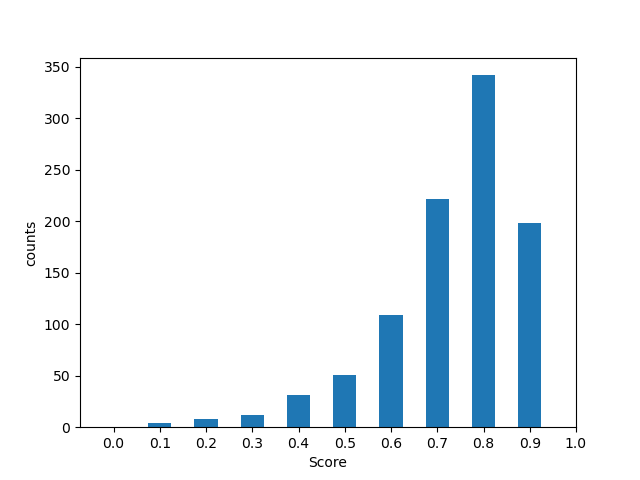

In [17]:
plt.figure()
plt.hist(scores,density=False,bins = np.arange(0,1.1,.1),align="left",rwidth = .5)
plt.ylabel("counts")
plt.xlabel("Score")
plt.xticks(np.arange(0,1.1,.1))

### Probability of running out of stock

"Dado N días y un stock S ¿Cuál es la probabilidad de quedarme sin stock en el día M?"  
Dada la distribución de probabilidades obtenida arriba, cada dia tiene una probabilidad $\sum_{y>S}P(y|x=M)$ de quedarse sin stock, donde $Y$ es el número de ventas acumuladas hasta el día M.  

Calculemos esta probabilidad

Text(0.5, 0, 'Days')

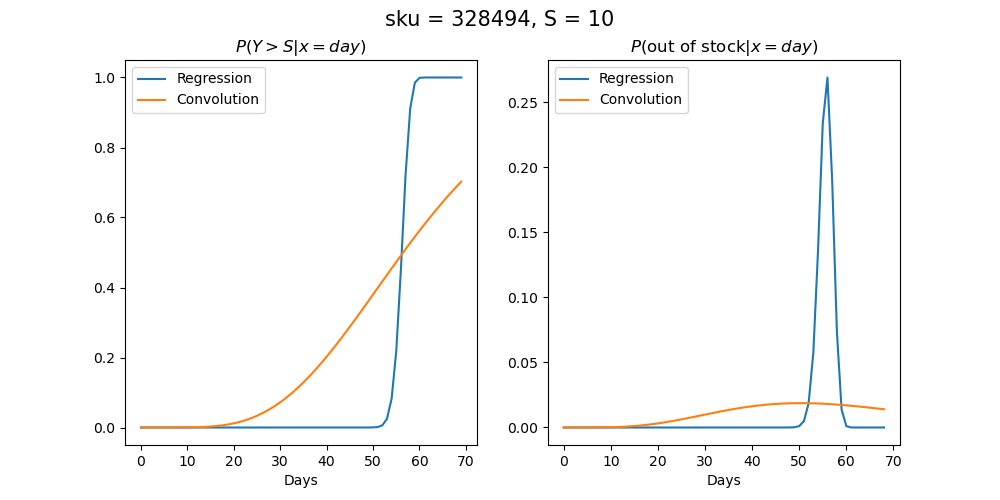

In [18]:
S = 10 #stock

sells = np.arange(50) # Las ventas oscilan entre 0 y 12 según el histograma
days = np.arange(70) # Días aproximados


p_stock_out = []
p2_stock_out = []
for day in days:
    p = Poisson(sells,day,clf.intercept_,clf.coef_[0])
    p /= p.sum() ### OJO! Debo renormalizar la distribución para que siga siendo una probabilidad. Why? float problems?
    stock_out = np.sum(p[S:])
    p_stock_out.append(stock_out)
    
    p2 = pdf_n_days(dist_prob,day)
    p2 /= p2.sum()
    stock_out2 = np.sum(p2[S:])
    p2_stock_out.append(stock_out2)

plt.close("all")
fig,axes = plt.subplots(1,2,figsize = (10,5),num = f"Probability of stock out sku = {sku}, S = {S}")
fig.suptitle(f"sku = {sku}, S = {S}",fontsize = 15)

axes[0].plot(p_stock_out,label = "Regression")
axes[0].plot(p2_stock_out,label = "Convolution")
axes[0].set_title("$P(Y>S|x = day)$")

axes[1].plot(np.diff(p_stock_out),label = "Regression")
axes[1].plot(np.diff(p2_stock_out),label = "Convolution")
axes[1].set_title("$P(\mathrm{out\ of\ stock}|x = day)$")


axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("Days")
axes[1].set_xlabel("Days")

### Apply to data

In [19]:
def Train_poisson_model(s,max_iter = 5000,alpha = 1):
    y = np.cumsum(s.sold_quantity)
    x = np.arange(y.size) 
    
    
    data = np.array([x,y]).T
    trans = MinMaxScaler()
    data = trans.fit_transform(data).T
    x,y = data
    
    x = x.reshape(-1,1)
    
    clf = linear_model.PoissonRegressor(alpha = alpha,max_iter = max_iter)
    clf.fit(x,y)
    
    coef = [clf.intercept_,clf.coef_[0],trans.scale_]
    return coef

In [20]:
sku_grouped = data_train[data_train.sku.isin(np.random.choice(data_train.sku.unique(),1000))].groupby("sku")
model = sku_grouped.apply(lambda x:Train_poisson_model(x))

/home/thungur/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/link.py:84: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred)
/home/thungur/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/home/thungur/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:315: RuntimeWarning: invalid value encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
/home/thungur/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/thungur/anaconda3/lib/python3.8/site-packages/sklearn/l

In [13]:
model.iloc[0]

[-0.6472469552446304, 0.09444295619126246, array([0.01724138, 0.04347826])]

In [5]:
plt.figure()
plt.plot(np.cumsum(data_train[data_train.sku == 659780].sold_quantity.values))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

UsageError: %%python3 is a cell magic, but the cell body is empty.
